In [1]:
!wget 'https://nextcloud.univ-lille.fr/index.php/s/fJCDx8XCRdzDg3y/download/img_align_celeba.npz'

zsh:1: command not found: wget


The prepared dataset can then be loaded as follows:

In [2]:
from numpy import load

# load the face dataset
data = load('img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'img_align_celeba.npz'

Once the images are loaded, plot them using the imshow() function from the matplotlib library.

In [4]:
import matplotlib.pyplot as plt
import math

In [39]:
def plot_faces(faces, n):
  fig = plt.figure()
  rows = 3
  columns = math.ceil(n/3)
  for i in range(1, n+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(faces[i-1])
    plt.axis('off')
    plt.title(str(i))
  

In [5]:
from keras.models import Sequential
import keras.layers as kl
from keras import optimizers
from keras.layers import LeakyReLU
import tensorflow as tf

In [ ]:
def define_discriminator(in_shape=(80,80,3)):
	"""Define the standalone discriminator model.

	Args:
		in_shape (tuple of integers): Input shape of the first layer.

	Returns:
		a keras model (keras.models.Sequential)
	"""
	model = Sequential()
		# extract 128 feature maps of size 80x80
	model.add(kl.Conv2D(filters=128, kernel_size = 5, strides=2, padding = "same", activation=LeakyReLU(0.2) , input_shape=in_shape))
		# downsample the 128 feature maps to 40x40
	model.add(kl.Conv2D(filters=128, kernel_size = 5, strides=2, padding = "same", activation=LeakyReLU(0.2)))
		# downsample the 128 feature maps to 20x20
	model.add(kl.Conv2D(filters=128, kernel_size = 5, strides=2, padding = "same", activation=LeakyReLU(0.2)))
		# downsample the 128 feature maps to 10x10
	model.add(kl.Conv2D(filters=128, kernel_size = 5, strides=2, padding = "same", activation=LeakyReLU(0.2)))
		# downsample the 128 feature maps to 5x5
		# classifier with dropout=0.4
	model.add(kl.Flatten())
	model.add(kl.Dropout(0.4))
	model.add(kl.Dense(512, activation = "ReLU"))
	model.add(kl.Dense(128, activation = "ReLU"))
	model.add(kl.Dense(1, activation = "sigmoid"))
		# compile model
	opt = optimizers.Adam(learning_rate =0.0002, beta_1=0.5)
	model.compile(loss = 'binary_crossentropy' , optimizer = opt ,metrics =['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim):
        """Define the standalone generator model.

        Args:
                latent_dim (int): dimension of the input latent.

        Returns:
                a keras model (keras.models.Sequential), not compiled.
        """        
        model = Sequential()
        # extract 128 feature maps of size 5x5 from the input latent of size latent_dim
        model.add(kl.Dense(128*5*5,"ReLU",input_dim=latent_dim))
        model.add(kl.Reshape((5,5,128)))
        model.add(kl.Conv2DTranspose(128, 4, strides = 2, activation=LeakyReLU(alpha=0.2), padding='same'))
        # upsample the 128 feature maps to 10x10
        model.add(kl.Conv2DTranspose(128, 4, strides = 2, activation=LeakyReLU(alpha=0.2), padding='same'))
        # upsample the 128 feature maps to 20x20
        model.add(kl.Conv2DTranspose(128, 4, strides = 2, activation=LeakyReLU(alpha=0.2), padding='same'))
        # upsample the 128 feature maps to 40x40
        model.add(kl.Conv2DTranspose(128, 4, strides = 2, activation=LeakyReLU(alpha=0.2), padding='same'))
        # upsample the 128 feature maps to 80x80
 
        model.add(kl.Conv2D(3, 4, strides = 1, activation="tanh", padding='same'))
        # output layer 80x80x3
        model.build()
        return model

In [6]:
from keras import Model

In [ ]:
def define_gan(g_model, d_model):
	"""Define the combined generator and discriminator model, for updating the generator.

	Args:
		g_model (keras.models.Sequential): generator model.
		d_model (keras.models.Sequential): discriminator model.

	Returns:
		a keras model (keras.models.Sequential)
	"""
	# make weights in the discriminator not trainable
	d_model.set_trainable = False
	# connect sequentially generator and discriminator models
	model = Model(inputs=g_model.input, outputs=d_model(g_model.output))
	# compile model
	opt = optimizers.Adam(learning_rate =0.0002, beta_1=0.5)
	model.compile(loss = 'binary_crossentropy' , optimizer = opt ,metrics =['accuracy'])
 
	return model

In [ ]:
g = define_generator(100)
d = define_discriminator()
define_gan(g,d).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 3200)              323200    
                                                                 
 reshape_1 (Reshape)         (None, 5, 5, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 10, 10, 128)      262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 20, 20, 128)      262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 40, 40, 128)      262272

In [7]:
import numpy as np

In [ ]:
def load_real_samples():
	"""Load and prepare training images.

	Returns:
		a numpy.ndarray containing normalized faces.
	"""
	# load the face dataset
	data = load('img_align_celeba.npz')
	faces = data['arr_0']
	# convert from unsigned ints to floats
	faces=faces.astype(np.float32)
	# scale from [0,255] to [-1,1]
	faces = (faces-122.5)/122.5
	return faces

In [ ]:
def generate_real_samples(dataset, n_samples):
	"""Select real samples.

	Args:
		dataset (numpy.ndarray): normalized faces.
		n_samples (int): number of samples randomly selected from the dataset (i.e. batch size).

	Returns:
		a tuple of numpy.ndarray with (1) the selected samples and (2) the 'real' class labels (i.e. ones(n_samples, 1)).
	"""
	z = np.zeros((n_samples,80,80,3))
	for i in range(n_samples):
		z[i]+=dataset[np.random.randint(0,50000)]
	return (z,np.ones(n_samples).reshape((-1,1)))


In [40]:
def generate_latent_points(latent_dim, n_samples):
	"""Generate points in latent space as input for the generator

	Args:
		latent_dim (int): Latent dimension.
		n_samples (int): number of generated samples.

	Returns:
		a numpy.ndarray of shape (n_samples, latent_dim).
	"""
	prod = latent_dim

 
	tab = np.random.normal(0,1,n_samples*prod)
	tab = tab.reshape((n_samples,latent_dim))
	return tab

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    """Use the generator to generate n fake examples, with class labels

    Args:
        g_model (keras.models.Sequential): generator model.
        latent_dim (int): Latent dimension.
        n_samples (int): number of generated samples.

    Returns:
        a tuple of numpy.ndarray with (1) the generated samples and (2) the 'fake' class labels (i.e. zeros(n_samples, 1)).
    """

    data = generate_latent_points(latent_dim, n_samples)
    z = g_model.predict(data)
    return (z,np.zeros(n_samples).reshape((-1,1)))



In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    """Evaluate the discriminator, plot generated images, save generator model

    Args:

        epoch (int): the current epoch during evaluation.
        g_model (keras.models.Sequential): generator model.
        d_model (keras.models.Sequential): discriminator model.
        dataset (numpy.ndarray): all normalized faces.
        latent_dim (int): Latent dimension.
        n_samples (int): number of generated samples.
    """
    # evaluate discriminator on real examples
    rs = generate_real_samples(dataset, n_samples)
    eval_r = d_model.evaluate(rs[0],rs[1])
    # evaluate discriminator on fake examples

    fs = generate_fake_samples(g_model, latent_dim, n_samples)
    eval_f = d_model.evaluate(fs[0],fs[1])
    # print discriminator performance
    print("real : ", eval_r, " /   fake : ", eval_f)
    # save plot
    plot_faces(fs[0],6)
    plt.savefig('plot' + str(epoch))
    # save the generator model tile file
    g_model.save("gene" + str(epoch))
    
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    """Train the generator and discriminator

    Args:
        g_model (keras.models.Sequential): generator model.
        d_model (keras.models.Sequential): discriminator model.
        gan_model (keras.models.Sequential): combined generator and discriminator model.
        dataset (numpy.ndarray): all normalized faces.
        latent_dim (int): Latent dimension.
        n_epoch (int): number of epochs during training.
        n_batch (int); number of samples by batch
    """
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # update discriminator model weights with 'real' samples (use the train_on_batch function with half_batch samples)
            rs = generate_real_samples(dataset, half_batch)
            d_model.train_on_batch(rs[0],rs[1])
            # update discriminator model weights with 'fake' samples (use the train_on_batch function with half_batch samples)
            fs = generate_fake_samples(g_model, latent_dim, half_batch)
            d_model.train_on_batch(fs[0],fs[1])
            # update the generator model weights (use the train_on_batch function with n_batch samples)
            lat_p = generate_latent_points(latent_dim, n_batch)
            gan_model.train_on_batch(lat_p, np.ones(n_batch).reshape(-1,1))
            # summarize loss on this batch
              #gan_model.compute_loss()
        # evaluate the model performance, sometimes
        summarize_performance(i, g_model, d_model, dataset, latent_dim, 100) 

We can then define the size of the latent space, define all three models, and train them on the loaded face dataset.

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

2/2 [==============================] - 3s 2s/step


In [32]:
!wget 'https://nextcloud.univ-lille.fr/index.php/s/stkf2XASKxsHaLD/download/generator_model_030.h5'

--2023-02-22 08:06:18--  https://nextcloud.univ-lille.fr/index.php/s/stkf2XASKxsHaLD/download/generator_model_030.h5
Resolving nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)... 194.254.129.23, 194.254.129.22
Connecting to nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)|194.254.129.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5564160 (5.3M) [application/octet-stream]
Saving to: ‘generator_model_030.h5.2’

generator_model_030 100%[===================>]   5.31M  4.61MB/s    in 1.2s    

2023-02-22 08:06:20 (4.61 MB/s) - ‘generator_model_030.h5.2’ saved [5564160/5564160]



In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

model = InceptionV3()

96112376/96112376 [==============================] - 1s 0us/step


In [3]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

87910968/87910968 [==============================] - 2s 0us/step


In [13]:
def scale_images(images, new_shape):
        """Scale an array of images to a new size

        Args:
                images (numpy.ndarray): array or list of images
                new_shape (tuple): new size for each image

        Returns:
                a numpy.array containing all resized images
        """
        images_list = list()
        for image in images:
        # resize with nearest neighbor interpolation
                new_image = np.resize(image, new_shape)
        # store
                images_list.append(new_image)
        return np.array(images_list)


In [26]:
import scipy.linalg as sl
def calculate_fid(model, images11, images22):

        # calculate features
        images1 = model.predict(images11)
        images2 = model.predict(images22)
        # calculate mean and covariance statistics
        mu1, sigma1 = images1.mean(axis=1), np.cov(images1, rowvar=True)
        mu2, sigma2 = images2.mean(axis=1), np.cov(images2, rowvar=True)
 # calculate sum squared difference between means
        smdiff = np.sum((mu1 - mu2)**2.0)

        # calculate sum squared difference between means
        ssdiff = np.sum((sigma1 - sigma2)**2.0)
        # calculate 'sqrt' of dot product between covariance matrices using scipy.linalg.sqrtm
        covmean = sl.sqrtm(sigma1.dot(sigma2))
 
        # if 'sqrt' is imaginary, take the real part
        if np.iscomplexobj(covmean):
                covmean = covmean.real
        # calculate fid score
        fid = ssdiff + (sigma1 + sigma2 - 2.0 * covmean).trace()

        return fid

In [11]:
# define two fake collections of images
images1 = np.random.randint(0, 255, 30720)
images1 = images1.reshape((10,32,32,3))
images2 = np.random.randint(0, 255, 30720)
images2 = images2.reshape((10,32,32,3))

In [14]:
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))

Then the pixel values can be scaled to meet the expectations of the Inception v3 model.

In [16]:
from keras.applications.inception_v3 import preprocess_input

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

Then calculate the FID scores, first between a collection of images and itself, then between the two collections of images.

In [30]:
# fid between images1 and images1 (should be equal to 0)
print(calculate_fid(model, images1, images1))
# fid between images1 and images2
print(calculate_fid(model, images1, images2))

1/1 [==============================] - 2s 2s/step
2.886579864025407e-15
1/1 [==============================] - 2s 2s/step
0.1540652407542002


Application for face generation: calculate the fid score from the real and generated face images.

## How to Explore the Latent Space for Generated Faces
In this section, we will use our trained GAN model as the basis for exploring the latent space.

The generator model can be downloaded as follows:

In [43]:
!wget 'https://nextcloud.univ-lille.fr/index.php/s/stkf2XASKxsHaLD/download/generator_model_030.h5'

--2023-02-22 08:16:45--  https://nextcloud.univ-lille.fr/index.php/s/stkf2XASKxsHaLD/download/generator_model_030.h5
Resolving nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)... 194.254.129.22, 194.254.129.23
Connecting to nextcloud.univ-lille.fr (nextcloud.univ-lille.fr)|194.254.129.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5564160 (5.3M) [application/octet-stream]
Saving to: ‘generator_model_030.h5.3’

generator_model_030 100%[===================>]   5.31M  4.59MB/s    in 1.2s    

2023-02-22 08:16:47 (4.59 MB/s) - ‘generator_model_030.h5.3’ saved [5564160/5564160]



### How to Load Model and Generate Faces
The first step is to load the saved model and confirm that it can generate plausible faces.

The model can be loaded using the load_model() function in the Keras API. We can then generate a number of random points in the latent space and use them as input to the loaded model to generate new faces. The faces can then be plotted.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3200)              323200    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 3200)              0         
                                                                 
 reshape (Reshape)           (None, 5, 5, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 10, 10, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 20, 20, 128)      262272    
 ranspose)                                            

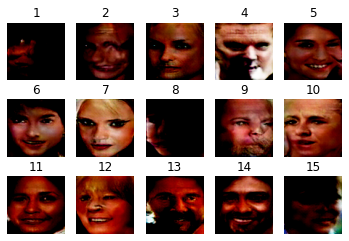

In [46]:
# load model
model_g = tf.keras.models.load_model("generator_model_030.h5.1")
model_g.compile()
model_g.summary()
# generate points in latent space
lp = generate_latent_points(100, 15)
# generate images
ims = model_g.predict(lp)
# plot the result
plot_faces(ims,15)